## IMPLEMENTACIÓN K-MEANS

In [9]:
import numpy as np
from sklearn.cluster import KMeans as KMeans_sklearn

# Implementación personalizada de K-Means
import numpy as np

class KMeans:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
       
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X):
        
        # Inicializar los centroides utilizando k-means++
        centroids = self._kmeans_plusplus(X)

        for _ in range(self.max_iter):
            # Asignar cada muestra al centroide más cercano
            labels = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1)

            # Recalcular los centroides como el promedio de las muestras asignadas a cada centroide
            new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.n_clusters)])

            # Verificar la convergencia
            if np.linalg.norm(new_centroids - centroids) < self.tol:
                break

            centroids = new_centroids

        self.centroids = centroids
        self.labels_ = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1)
        return self

    def predict(self, X):
    
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=-1), axis=-1)

    def _kmeans_plusplus(self, X):
       
        centroids = np.zeros((self.n_clusters, X.shape[1]))
        centroids[0] = X[np.random.choice(X.shape[0])]
        
        for i in range(1, self.n_clusters):
            distances = np.array([min([np.linalg.norm(x - c) for c in centroids[:i]]) for x in X])
            probabilities = distances / distances.sum()
            cumulative_probabilities = probabilities.cumsum()
            rand = np.random.rand()
            for j, p in enumerate(cumulative_probabilities):
                if rand < p:
                    centroids[i] = X[j]
                    break
        
        return centroids


# predict...
# make_blobs, para comparar kmeans evaluacionnn lo hace en el tutorial
"""Ver a ojo dibujando seis características noooo
Correlacion dibujando matriz y juntar(temperatura con color)
1) ESCALAR
2) PCA DOS O TRES NO VAMOS A PODER PINTAR MÁS.UTILIZANDO COMPONENTES PRINCIPALES.
3) PRUEBA CON DOS¿?QUE VARIABILIDAD, CERCA DE 80 OKEYYYY, SOLO DOS, SINO PRUEBA CON TRES
4) SI ES CON TRES QUE SE PUEDA MOVER CON EL RATON. EL CHIVA QUE DOSSSS Y PINTASSS.
5) JERARQUICO, KMEANS, DBSCAN, ETC.
6) 6-7 CLUSTERS, HAY QUE CARACTERIZARLAS Y GENERAR BOX-PLOTS PARA CADA CLASE Y VER COMO SE DIVIDEN
LAS CARACTERÍSTICAS
7)VER VALORES DE CIENTIFICOS Y CARACTERIZAR, SE PUEDE PROBAR ARBOL DE DECISIÓN"""

# Cargar los datos


Etiquetas obtenidas con la implementación personalizada:
[0 0 0 0 2 1 2 0 2 2 1 2 0 0 0 1 2 2 2 2 0 0 1 1 2 0 2 2 1 0 0 0 1 2 0 1 1
 1 1 1 0 0 0 2 1 2 0 1 0 0 1 2 1 0 0 1 2 0 2 0 0 0 1 1 2 2 2 0 0 2 2 0 2 0
 1 0 2 2 2 1 1 0 2 2 2 1 1 0 0 1 0 1 2 1 1 2 1 2 2 2]

Etiquetas obtenidas con la implementación de scikit-learn:
[1 1 2 2 2 0 0 2 0 0 0 0 1 1 1 0 2 2 0 0 1 2 0 0 0 1 0 2 0 2 1 2 0 0 2 0 0
 0 0 0 1 1 2 0 0 2 2 0 1 1 0 2 1 1 1 0 0 1 2 1 1 1 0 0 0 0 0 1 1 0 2 2 0 2
 0 1 0 2 0 0 0 2 0 2 0 0 0 1 1 0 2 1 0 0 0 2 0 0 0 2]


     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12    Red              M
1           3042       0.000500     0.1542  16.60    Red              M
2           2600       0.000300     0.1020  18.70    Red              M
3           2800       0.000200     0.1600  16.65    Red              M
4           1939       0.000138     0.1030  20.06    Red              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93   Blue              O
236        30839  834042.000000  1194.0000 -10.63   Blue              O
237         8829  537493.000000  1423.0000 -10.73  White              A
238         9235  404940.000000  1112.0000 -11.23  White              A
239        37882  294903.000000  1783.0000  -7.80   Blue              O

[240 rows x 6 columns]


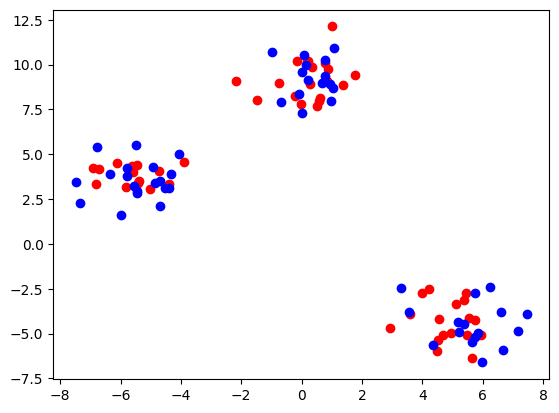

In [2]:
# Cargar los datos del csv
import pandas as pd

# Archivo CSV a cargar
archivo = "Stars2.csv"

# Cargamos el archivo y lo mostramos por pantalla
print(pd.read_csv(archivo))

data_set = pd.read_csv(archivo)  # Guardamos en data_set la información del archivo CSV

data_set.head()


In [18]:
# Preparar los datos

import pandas as pd

# Carga tu archivo csv
df = pd.read_csv('Stars2.csv')

# Reemplaza los valores incorrectos en la columna 'color'
df['Color'] = df['Color'].replace(['Blue White', 'Blue white', 'Blue-White'], 'Blue-white')
df['Color'] = df['Color'].replace(['white'], 'White')
df['Color'] = df['Color'].replace(['yellowish-white'], 'Yellowish White')
df['Color'] = df['Color'].replace(['yellowish'], 'Yellowish')


corregido = pd.read_csv('Stars2.csv')
corregido.head()


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


In [20]:
import pandas as pd

# Define el orden de los colores
color_order = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish', 
               'yellow-white', 'Whitish', 'Yellowish White', 'White-Yellow', 'White', 
               'Blue-white', 'Blue']

# Encuentra los valores únicos en la columna "Color"
unique_colors = set(corregido['Color'])

# Encuentra los valores de la columna "Color" que no están en color_order
missing_colors = unique_colors - set(color_order)

# Imprime los valores que faltan
print("Valores de la columna Color que no están en color_order:")
for color in missing_colors:
    print(color)

# Define el diccionario de mapeo para corregir los valores incorrectos
correction_mapping = {
    'Blue white': 'Blue-white',
    'Blue White': 'Blue-white',
    'Blue-White': 'Blue-white',
    'white': 'White',
    'yellowish': 'Yellowish'
}

# Reemplaza los valores incorrectos en la columna "Color"
corregido['Color'] = corregido['Color'].replace(correction_mapping)

# Mapea los valores de color utilizando una función lambda
corregido['Color'] = corregido['Color'].map(lambda x: color_order.index(x))

# Muestra el DataFrame con la columna 'Color' reemplazada por los valores codificados
print(corregido)


Valores de la columna Color que no están en color_order:
Blue white
Blue White
Blue-White
white
yellowish
     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12      0              M
1           3042       0.000500     0.1542  16.60      0              M
2           2600       0.000300     0.1020  18.70      0              M
3           2800       0.000200     0.1600  16.65      0              M
4           1939       0.000138     0.1030  20.06      0              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93     11              O
236        30839  834042.000000  1194.0000 -10.63     11              O
237         8829  537493.000000  1423.0000 -10.73      9              A
238         9235  404940.000000  1112.0000 -11.23      9              A
239        37882  294903.000000  1783.0000  -7.80     11              O

[240 rows x 6 columns]


In [21]:
import pandas as pd

# Definir el orden de las clases espectrales (de menor a mayor)
spectral_class_order = ['O', 'B', 'A', 'F', 'G', 'K', 'M']


# Mapear los valores de spectral_class utilizando una función lambda
corregido['Spectral_Class'] = corregido['Spectral_Class'].map(lambda x: spectral_class_order.index(x))

# Muestrar el DataFrame con la columna 'Spectral_Class' reemplazada por los valores codificados
print(corregido)


     Temperature              L          R    A_M  Color  Spectral_Class
0           3068       0.002400     0.1700  16.12      0               6
1           3042       0.000500     0.1542  16.60      0               6
2           2600       0.000300     0.1020  18.70      0               6
3           2800       0.000200     0.1600  16.65      0               6
4           1939       0.000138     0.1030  20.06      0               6
..           ...            ...        ...    ...    ...             ...
235        38940  374830.000000  1356.0000  -9.93     11               0
236        30839  834042.000000  1194.0000 -10.63     11               0
237         8829  537493.000000  1423.0000 -10.73      9               2
238         9235  404940.000000  1112.0000 -11.23      9               2
239        37882  294903.000000  1783.0000  -7.80     11               0

[240 rows x 6 columns]
